Lambda School Data Science

*Unit 2, Sprint 3, Module 3*

---


# Permutation & Boosting

You will use your portfolio project dataset for all assignments this sprint.

## Assignment

Complete these tasks for your project, and document your work.

- [ ] If you haven't completed assignment #1, please do so first.
- [ ] Continue to clean and explore your data. Make exploratory visualizations.
- [ ] Fit a model. Does it beat your baseline? 
- [ ] Try xgboost.
- [ ] Get your model's permutation importances.

You should try to complete an initial model today, because the rest of the week, we're making model interpretation visualizations.

But, if you aren't ready to try xgboost and permutation importances with your dataset today, that's okay. You can practice with another dataset instead. You may choose any dataset you've worked with previously.

The data subdirectory includes the Titanic dataset for classification and the NYC apartments dataset for regression. You may want to choose one of these datasets, because example solutions will be available for each.


## Reading

Top recommendations in _**bold italic:**_

#### Permutation Importances
- _**[Kaggle / Dan Becker: Machine Learning Explainability](https://www.kaggle.com/dansbecker/permutation-importance)**_
- [Christoph Molnar: Interpretable Machine Learning](https://christophm.github.io/interpretable-ml-book/feature-importance.html)

#### (Default) Feature Importances
  - [Ando Saabas: Selecting good features, Part 3, Random Forests](https://blog.datadive.net/selecting-good-features-part-iii-random-forests/)
  - [Terence Parr, et al: Beware Default Random Forest Importances](https://explained.ai/rf-importance/index.html)

#### Gradient Boosting
  - [A Gentle Introduction to the Gradient Boosting Algorithm for Machine Learning](https://machinelearningmastery.com/gentle-introduction-gradient-boosting-algorithm-machine-learning/)
  - [An Introduction to Statistical Learning](http://www-bcf.usc.edu/~gareth/ISL/ISLR%20Seventh%20Printing.pdf), Chapter 8
  - _**[Gradient Boosting Explained](https://www.gormanalysis.com/blog/gradient-boosting-explained/)**_ — Ben Gorman
  - [Gradient Boosting Explained](http://arogozhnikov.github.io/2016/06/24/gradient_boosting_explained.html) — Alex Rogozhnikov
  - [How to explain gradient boosting](https://explained.ai/gradient-boosting/) — Terence Parr & Jeremy Howard

#Fit a model. Does it beat your baseline?

In [28]:
import numpy as np
import pandas as pd

uci_red = pd.read_csv('https://raw.githubusercontent.com/nastyalolpro/project_data/master/build_week_2/winequality-red.csv', delimiter=";")
uci_white = pd.read_csv('https://raw.githubusercontent.com/nastyalolpro/project_data/master/build_week_2/winequality-white.csv', delimiter=";")

uci_red['color'] = 'red'
uci_white['color'] = 'white'

df = pd.concat([uci_red, uci_white])
df = df.reset_index(drop=True)

In [30]:
df['color'].value_counts(normalize = True)

white    0.753886
red      0.246114
Name: color, dtype: float64

In [33]:
from sklearn.model_selection import train_test_split

train, test = train_test_split(df, train_size=0.80, test_size=0.20, 
                              stratify=df['quality'], random_state=42)

In [34]:
train, val = train_test_split(train, train_size=0.80, test_size=0.20, 
                              stratify=train['quality'], random_state=42)

###Want to check distribution

In [35]:
train['color'].value_counts(normalize = True)

white    0.756074
red      0.243926
Name: color, dtype: float64

In [36]:
test['color'].value_counts(normalize = True)

white    0.764615
red      0.235385
Name: color, dtype: float64

In [37]:
val['color'].value_counts(normalize = True)

white    0.731731
red      0.268269
Name: color, dtype: float64

##Baseline

In [38]:
#target distribution
dist = train['quality'].value_counts(normalize = True)
dist

6    0.436613
5    0.329083
7    0.165985
4    0.033438
8    0.029589
3    0.004571
9    0.000722
Name: quality, dtype: float64

In [9]:
print('Baseline is', dist.max())

Baseline is 0.43650915807295676


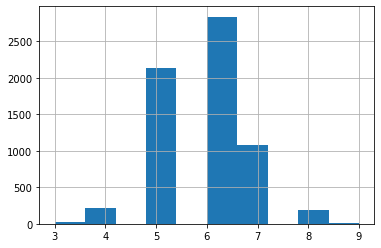

In [18]:
#1-10, what if some classes are missing?
import matplotlib.pyplot as plt

df['quality'].hist();

In [39]:
train.isnull().sum()

fixed acidity           0
volatile acidity        0
citric acid             0
residual sugar          0
chlorides               0
free sulfur dioxide     0
total sulfur dioxide    0
density                 0
pH                      0
sulphates               0
alcohol                 0
quality                 0
color                   0
dtype: int64

In [40]:
train.dtypes

fixed acidity           float64
volatile acidity        float64
citric acid             float64
residual sugar          float64
chlorides               float64
free sulfur dioxide     float64
total sulfur dioxide    float64
density                 float64
pH                      float64
sulphates               float64
alcohol                 float64
quality                   int64
color                    object
dtype: object

In [41]:
train.describe()

,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol,quality
count,4157.000000,4157.000000,4157.000000,4157.000000,4157.000000,4157.000000,4157.00000,4157.000000,4157.000000,4157.000000,4157.000000,4157.000000
mean,7.216839,0.338441,0.316704,5.500301,0.055568,30.785903,116.47426,0.994756,3.218821,0.530630,10.455239,5.817657
std,1.282094,0.164193,0.146342,4.723909,0.034105,17.863918,56.72208,0.002939,0.161270,0.145386,1.178301,0.872776
min,4.200000,0.080000,0.000000,0.600000,0.009000,1.000000,6.00000,0.987220,2.720000,0.250000,8.000000,3.000000
25%,6.400000,0.230000,0.240000,1.800000,0.038000,17.000000,79.00000,0.992400,3.110000,0.430000,9.500000,5.000000
50%,7.000000,0.290000,0.310000,3.100000,0.047000,29.000000,119.00000,0.994900,3.210000,0.510000,10.300000,6.000000
75%,7.700000,0.400000,0.390000,8.200000,0.064000,42.000000,157.00000,0.997010,3.320000,0.600000,11.300000,6.000000
max,15.600000,1.330000,1.660000,31.600000,0.611000,289.000000,440.00000,1.010300,4.010000,1.950000,14.200000,9.000000


##Arrange data into X features matrix and y target vector

In [ ]:
target = 'quality'

X_train = train.drop(columns = target)
y_train = train[target]

X_val = val.drop(columns = target)
y_val = val[target]

X_test = test.drop(columns = target)
y_test = test[target]

##Random forest classifier

In [12]:
!pip install category_encoders==2.*

     |████████████████████████████████| 81kB 2.2MB/s 


In [47]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.pipeline import make_pipeline
# from sklearn.impute import SimpleImputer
import category_encoders as ce

In [77]:
pipeline = make_pipeline(
    ce.OrdinalEncoder(), 
    RandomForestClassifier(max_depth = 30, n_estimators=100, random_state=42, n_jobs=-1)
    )

pipeline.fit(X_train, y_train)
score_with = pipeline.score(X_val, y_val)
print(f'Validation Accuracy: {score_with}')

Validation Accuracy: 0.6567307692307692


##(Default) feature umportances

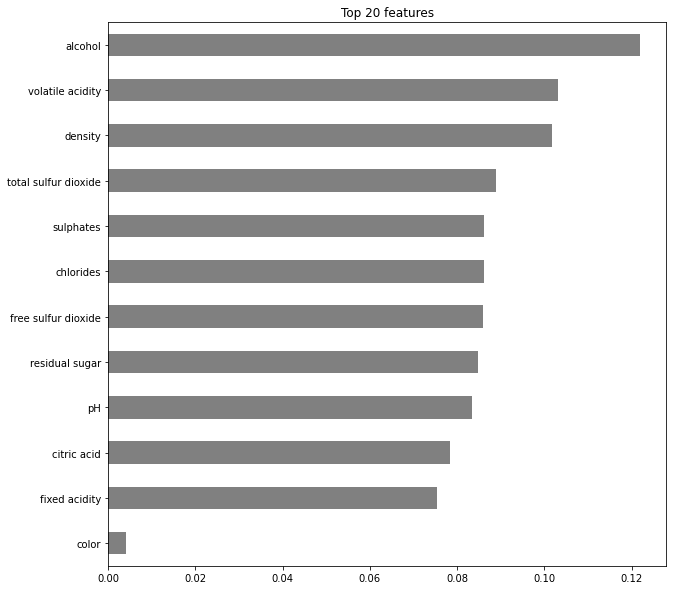

In [78]:
rf = pipeline.named_steps['randomforestclassifier']
importances = pd.Series(rf.feature_importances_, X_train.columns)

n=20
plt.figure(figsize=(10,n/2))
plt.title(f'Top {n} features')
importances.sort_values()[-n:].plot.barh(color='grey');

#Try xgboost.

In [55]:
from xgboost import XGBClassifier

pipeline = make_pipeline(
    ce.OrdinalEncoder(), 
    XGBClassifier(n_estimators=100, random_state=42, n_jobs=-1)
    )

pipeline.fit(X_train, y_train)
score_with = pipeline.score(X_val, y_val)
print(f'Validation Accuracy: {score_with}')

Validation Accuracy: 0.5644230769230769


###Early stopping of the model

In [67]:
encoder = ce.OrdinalEncoder()

X_train_encoded = encoder.fit_transform(X_train)
X_val_encoded = encoder.transform(X_val)

model = XGBClassifier(
    n_estimators = 1000, 
    max_depth = 7, 
    learning_rate = .2,
    n_jobs = -1
)

eval_set = [(X_train_encoded, y_train), 
            (X_val_encoded, y_val)]

model.fit(X_train_encoded, y_train, 
          eval_set=eval_set, 
          eval_metric='merror', 
          early_stopping_rounds=50)

[0]	validation_0-merror:0.324032	validation_1-merror:0.441346
Multiple eval metrics have been passed: 'validation_1-merror' will be used for early stopping.

Will train until validation_1-merror hasn't improved in 50 rounds.
[1]	validation_0-merror:0.29733	validation_1-merror:0.439423
[2]	validation_0-merror:0.277123	validation_1-merror:0.422115
[3]	validation_0-merror:0.255232	validation_1-merror:0.428846
[4]	validation_0-merror:0.242483	validation_1-merror:0.423077
[5]	validation_0-merror:0.233341	validation_1-merror:0.424038
[6]	validation_0-merror:0.225162	validation_1-merror:0.419231
[7]	validation_0-merror:0.216743	validation_1-merror:0.419231
[8]	validation_0-merror:0.208804	validation_1-merror:0.414423
[9]	validation_0-merror:0.203753	validation_1-merror:0.411538
[10]	validation_0-merror:0.196295	validation_1-merror:0.408654
[11]	validation_0-merror:0.187154	validation_1-merror:0.399038
[12]	validation_0-merror:0.18114	validation_1-merror:0.401923
[13]	validation_0-merror:0.173

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, gamma=0,
              learning_rate=0.2, max_delta_step=0, max_depth=7,
              min_child_weight=1, missing=None, n_estimators=1000, n_jobs=-1,
              nthread=None, objective='multi:softprob', random_state=0,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
              silent=None, subsample=1, verbosity=1)

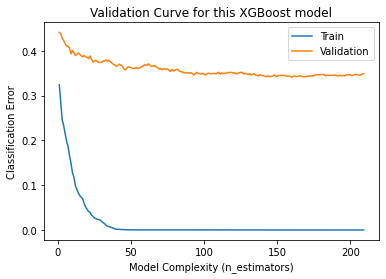

In [60]:
results = model.evals_result()
train_error = results['validation_0']['merror']
val_error = results['validation_1']['merror']
epoch = list(range(1, len(train_error)+1))
plt.plot(epoch, train_error, label='Train')
plt.plot(epoch, val_error, label='Validation')
plt.ylabel('Classification Error')
plt.xlabel('Model Complexity (n_estimators)')
plt.title('Validation Curve for this XGBoost model')
#plt.ylim((0.18, 0.22)) # Zoom in
plt.legend();

In [68]:
# do i need to try regression model ar try ajusting classes?
score_with = model.score(X_val_encoded, y_val)
print(f'Validation Accuracy: {score_with}')

Validation Accuracy: 0.6673076923076923


#Get your model's permutation importances.

In [71]:
!pip install eli5
import eli5
from eli5.sklearn import PermutationImportance

In [72]:
permuter = PermutationImportance(
    model,
    scoring = 'accuracy',
    n_iter=5, 
    random_state=42
)

permuter.fit(X_val_encoded, y_val)

PermutationImportance(cv='prefit',
                      estimator=XGBClassifier(base_score=0.5, booster='gbtree',
                                              colsample_bylevel=1,
                                              colsample_bynode=1,
                                              colsample_bytree=1, gamma=0,
                                              learning_rate=0.2,
                                              max_delta_step=0, max_depth=7,
                                              min_child_weight=1, missing=None,
                                              n_estimators=1000, n_jobs=-1,
                                              nthread=None,
                                              objective='multi:softprob',
                                              random_state=0, reg_alpha=0,
                                              reg_lambda=1, scale_pos_weight=1,
                                              seed=None, silent=None,
                    

In [75]:
feature_names = X_val_encoded.columns.tolist()
pd.Series(permuter.feature_importances_, feature_names).sort_values()

color                   0.002115
fixed acidity           0.021731
citric acid             0.039038
pH                      0.040385
chlorides               0.043462
residual sugar          0.052308
free sulfur dioxide     0.054231
density                 0.057115
sulphates               0.060385
total sulfur dioxide    0.062115
volatile acidity        0.088462
alcohol                 0.115577
dtype: float64

In [76]:
eli5.show_weights(
    permuter,
    top = None,
    feature_names = feature_names
)

Weight,Feature
0.1156 ± 0.0181,alcohol
0.0885 ± 0.0202,volatile acidity
0.0621 ± 0.0106,total sulfur dioxide
0.0604 ± 0.0234,sulphates
0.0571 ± 0.0134,density
0.0542 ± 0.0093,free sulfur dioxide
0.0523 ± 0.0083,residual sugar
0.0435 ± 0.0116,chlorides
0.0404 ± 0.0089,pH
0.0390 ± 0.0191,citric acid
